This Jupyter notebook is intended to replicate the experiments conducted in the study by Sidulova et al. (2023). Compared to the implementation used for Sidulova et al. (2023), this notebook is utilizing the enhanced and restructured *DomId* Python library. It is important to acknowledge that there may be slight variations in the results when compared to the original study, primarily due to the non-fixed random seed which introduces an element of stochastic variability.

Sidulova, M., Sun, X., & Gossmann, A. (2023). Deep Unsupervised Clustering for Conditional Identification of Subgroups Within a Digital Pathology Image Set. In H. Greenspan, A. Madabhushi, P. Mousavi, S. Salcudean, J. Duncan, T. Syeda-Mahmood, & R. Taylor (Eds.), Medical Image Computing and Computer Assisted Intervention – MICCAI 2023 (Vol. 14227, pp. 666–675). Springer Nature Switzerland. https://doi.org/10.1007/978-3-031-43993-3_64

In [1]:
import os
import pickle
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from domid.arg_parser import mk_parser_main
from domid.mk_exp import mk_exp
from domid.models.model_ae import mk_ae
from domid.models.model_sdcn import mk_sdcn

In [2]:
HER2_PATH = '/storage6T/HER2/Testing_fixed/categorized/combined_train/'

# this is to make sure results are saved in the directory structure as expected
os.chdir('../')
os.getcwd()

'/storage2T/github/DomId'

## Helper Functions

In [3]:
def get_most_recent_directory(directory):
    try:
        directories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
        directories.sort(key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)
        return os.path.join(directory, directories[0])
    except Exception as e:
        print("Error:", e)
        return None

In [4]:
def load_files(path):
    df = pd.read_csv(os.path.join(path, 'clustering_results.csv'))
    
    domain = df['predictions'].values
    
    vec_d = df['vec_d_labels'].values
    vec_y = df['vec_y_labels'].values
    img_locs = df['image_id_labels'].values

    Z = np.load(os.path.join(path, "Z_space.npy"))
    model_name = path.split('_')[-1]
    with open(os.path.join(path, 'commandline_arguments.p'), 'rb') as file:
        command_line = pickle.load(file)
    
    return domain, vec_d, vec_y, img_locs, model_name, command_line

In [5]:
def something_per_domain(domain, another_label):
    """
    domain - predicted domain labels 
    another_label - some other label that corresponds to each of the predicted domain (
    assumed that both domain and something have the same img_loc reference order 
    """
    u_something = np.unique(another_label)
    u_domain = np.unique(domain)
    print('unique predicted domain', u_domain)
    print('unique true label', u_something)
    
    array_counters=[]
    for i in u_domain:
        for j in u_something:
            counter = 0
            for idx in range(0, len(domain)):
                if domain[idx]==i and another_label[idx]==j:
                    counter+=1
            
            array_counters.append(counter)
    return array_counters

In [6]:
def plot_something_per_domain_proportion(domain, another_label, counts, fs, legend = False, thres = None, title = None, digit_plot = True):
    """
    domain - predicted domain labels
    another_label - another label aassociated with each predicted domain (should be same shape as domain)
    counts - countes of each another label in each of the predicted domain (see something_per_domain function)
    fs - font size
    colors - colors of each segment on the bargraph
    legend - legend of unique another lables
    thres - if thresholding of another label is required then should be shpecifies (also see apply_threshold function)
    
    """
    u_domains = np.unique(domain)
    N = len(u_domains)
    
    u_another_label = np.unique(another_label)
    print('unique labels', u_another_label)
    print(u_domains)
    counts = np.array(counts)
    narray = np.array_split(counts, N)

    if thres:
        u_another_label_dic = apply_threshold(u_another_label, narray, thres, N)
        #print(u_another_label_dic.values())
        u_another_label = list(u_another_label_dic.keys())
        narray = list(u_another_label_dic.values())
        narray = np.transpose(narray)

   # print(narray)
    #print(len(u_domains), len(u_another_label))
    # c = ['blue', 'teal', 'pink', 'orange', 'green', 'red', 'plum', 'grey', 'purple', 'yellow']
    # c = ['lightblue', 'steelblue', 'royalblue', 'mediumpurple', 'darkmagenta','orchid', 'lightpink', 'lightcoral', 'maroon', 'sandybrown']
    
    if digit_plot:
        c =  ['darkseagreen', 'forestgreen', 'aquamarine', 'lightseagreen', 'teal', 'steelblue','lightblue', 'royalblue','navy', 'lightslategrey' ]

    else:
        c = ['mediumpurple', 'darkmagenta','orchid', 'lightpink', 'lightcoral', 'maroon', 'sandybrown', 'peachpuff', 'goldenrod', 'gold']
  
        
    plt.figure(figsize = (5, 5))
    for i in range(0, len(u_domains)):
        for jj in range(0,len(u_another_label)):
            
            if jj>0:
                bottom = np.sum(narray[i][:jj])/np.sum(narray[i])
            else:
                bottom = 0
            ##print(i, narray[i][jj])
            #print(c[jj])
            plt.bar(i, narray[i][jj]/np.sum(narray[i]), bottom = bottom, color = c[jj])
    x = np.linspace(0, N-1, N)
    x_ticks = [str(item) for item in u_domains]
    #plt.ylabel("Proportion", fontsize=fs)
    plt.xticks(x, x_ticks, fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel("Domain", fontsize=fs)
    plt.title(title, fontsize = fs, weight = 'bold')
    plt.tick_params(left = False, labelleft = False)
    if legend:
        plt.legend(legend, bbox_to_anchor=(1, 1.1))
    else:
        plt.legend(u_another_label, bbox_to_anchor=(1, 1.1), fancybox=True, shadow=True, fontsize = fs)
    plt.show()

In [7]:
def get_last_created_directory(path):
    directories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    directories.sort(key=lambda x: os.path.getctime(os.path.join(path, x)), reverse=True)
    if directories:
        return directories[0]
    else:
        return None

## VaDe Experiments with HER2 data

In [9]:
exp = mk_exp(task='her2',model='vade',trainer='cluster', train_domain ="0 1 2", test_domain="0", batchsize="4",
             dpath= HER2_PATH, zd_dim='500', model_method ='cnn',
             prior='Gaus', pre_tr=17, epos=50, d_dim='3',lr='0.000005', nocu=False, L=5)

The sets of training and test domains overlap -- be aware of data leakage or training to the test!


Namespace(config_file=None, lr=5e-06, gamma_reg=0.1, es=1, seed=0, nocu=False, device=None, gen=False, keep_model=False, epos=50, epos_min=0, epo_te=1, warmup=100, debug=False, dmem=False, no_dump=False, trainer='cluster', out='zoutput', dpath='/storage6T/HER2/Testing_fixed/categorized/combined_train/', tpath=None, npath=None, npath_dom=None, npath_argna2val=None, nname_argna2val=None, nname=None, nname_dom=None, apath=None, exptag='exptag', aggtag='aggtag', bm_dir=None, plot_data=None, outp_dir='zoutput/benchmarks/shell_benchmark', param_idx=True, msel='val', model='vade', acon=None, task='her2', bs=4, split=0, te_d=['0'], tr_d=['0', '1', '2'], san_check=False, san_num=8, loglevel='DEBUG', zd_dim=500, zx_dim=0, zy_dim=64, topic_dim=3, nname_encoder_x2topic_h=None, npath_encoder_x2topic_h=None, nname_encoder_sandwich_x2h4zd=None, npath_encoder_sandwich_x2h4zd=None, gamma_y=None, gamma_d=None, beta_t=1.0, beta_d=1.0, beta_x=1.0, beta_y=1.0, tau=0.05, epos_per_match_update=5, epochs_ctr=

/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(

using device: cuda

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


ConvolutionalEncoder(
  (encod): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (mu_layer): Linear(in_features=2048, out_features=500, bias=True)
  (log_sigma2_layer): Linear(in_features=2048, out_features=500, bias=True)
)
ConvolutionalDecoder(
  (linear): Linear(in_features=500, out_features=2048, bias=True)
  (sigmoid_layer): Sigmoid()
  (unflat): UnFlatten()
  (decod)




!!!: not committed yet
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/utils/get_git_tag.py:16: UserWarning: !!!: not committed yet
  warnings.warn("!!!: not committed yet")



b'7a7eb4e'
The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(
model name: her2_te_class0_vade_b7a7eb4e_not_commited_2024md_04md_17_09_30_14_seed_0


############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________


In [ ]:
exp.execute()


 Experiment start at : 2024-04-17 09:30:14.305583
before training, model accuracy: (0.5, array([[336, 168, 168],
       [  0,   0,   0],
       [  0,   0,   0]]), 0.5416666666666666, array([[364,  60, 248],
       [  0,   0,   0],
       [  0,   0,   0]]))
Epoch 1. Pretraining.


/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[nan, nan, nan, nan, nan, nan]


/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[nan, nan, nan, nan, nan, nan]
pi:
[0.33405268 0.2710328  0.39491448]
epoch: 1
[-0.07986715336975174, 0.07791819812188372, -0.007125049404089681, 0.007125049404089714, -0.05359547522314192, -0.04498619956192828]
[0.00168889068810923, 0.04007511364402552, 0.04677078238118435, -0.04677078238118437, 0.0261659718789216, -0.05167894004232679]
pooled train clustering acc (vec_d correlation):  0.375
[[ 76  22 119]
 [ 61  16  85]
 [111  22 160]]
clustering validation acc:  0.40327380952380953
[[ 81  19 107]
 [ 52  13  80]
 [115  28 177]]
pooled train clustering acc (vec_y correlation):  0.36607142857142855
[[ 60  58  89]
 [ 35  35  75]
 [ 73  75 172]]
Correlation with HER2 scores training 0.07791819812188372
Correlation with HER2 scores validation 0.04677078238118435
now:  2024-04-17 09:30:59.612599 epoch time:  0:00:45.307016 used:  0:00:45.307016
Epoch 2. Pretraining.
[-0.013193719828367553, -0.03747260115956395, -0.05795286064002387, 0.05795286064002387, -0.03825744061308489, 0.057681403502

/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[-0.32432872803523854, 0.32432872803523843, 0.32432872803523843, -0.32432872803523854, nan, -0.32432872803523854]


/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[-0.3722756430580572, 0.37227564305805716, 0.37227564305805716, -0.3722756430580572, nan, -0.3722756430580572]
pooled train clustering acc (vec_d correlation):  0.6086309523809523
[[  0   0   0]
 [ 50 246  85]
 [ 10 118 163]]
clustering validation acc:  0.6086309523809523
[[  0   0   0]
 [ 44 250  89]
 [ 16 114 159]]
pooled train clustering acc (vec_y correlation):  0.4211309523809524
[[  0   0   0]
 [119 185  79]
 [ 49 151  89]]
Correlation with HER2 scores training 0.32432872803523843
Correlation with HER2 scores validation 0.37227564305805716
now:  2024-04-17 09:33:11.681523 epoch time:  0:00:45.233730 used:  0:02:57.375940
Epoch 5. Pretraining.


/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[-0.35885623329816135, 0.35885623329816124, 0.35885623329816124, -0.35885623329816124, nan, -0.35885623329816135]


/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[-0.39179498176091293, 0.39179498176091293, 0.39179498176091293, -0.39179498176091293, nan, -0.39179498176091293]
pi:
[0.50062233 0.08936232 0.41001537]
epoch: 5
[-0.4120306597501407, 0.4004228114528859, -0.4074284988212407, 0.4074284988212406, -0.41228848739683543, 0.02017429089529118]
[-0.41605069835552455, 0.3990248707056763, -0.4113690297244968, 0.4113690297244967, -0.41689498038122014, 0.03060605158650029]
pooled train clustering acc (vec_d correlation):  0.6101190476190477
[[239  44  76]
 [  4   1   2]
 [121  15 170]]
clustering validation acc:  0.6041666666666666
[[235  46  71]
 [  6   1   7]
 [123  13 170]]
pooled train clustering acc (vec_y correlation):  0.41220238095238093
[[119  77 156]
 [  5   2   7]
 [ 44  89 173]]
Correlation with HER2 scores training 0.4074284988212406
Correlation with HER2 scores validation 0.4113690297244967
now:  2024-04-17 09:33:53.111849 epoch time:  0:00:41.430326 used:  0:03:38.806266
Epoch 6. Pretraining.
[-0.3944659434662801, 0.3691884999363564

In [ ]:
vade_path = get_last_created_directory('./notebooks/')
print(vade_path)

In [30]:
domain, vec_d, vec_y, img_locs, model_name, command_line = load_files('./notebooks/'+vade_path)

unique predicted domain [1 2 3]
unique true label [0 1 2]
unique labels [0 1 2]
[1 2 3]


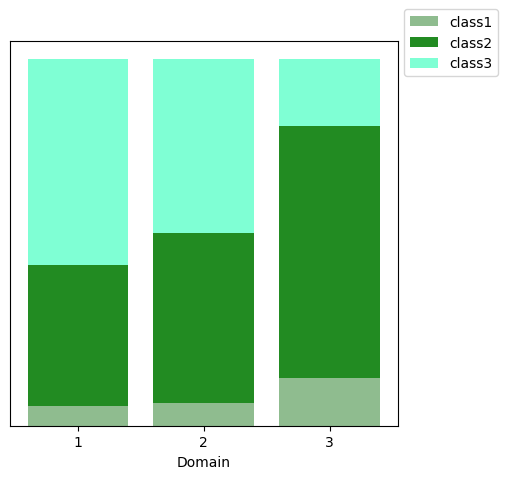

In [31]:
vec_d_counters = something_per_domain(domain, vec_d)
plot_something_per_domain_proportion(domain, vec_d, vec_d_counters, 10, legend = ['class1', 'class2', 'class3'], thres = None, title = None, digit_plot = True)

unique predicted domain [1 2 3]
unique true label [0 1 2]
unique labels [0 1 2]
[1 2 3]


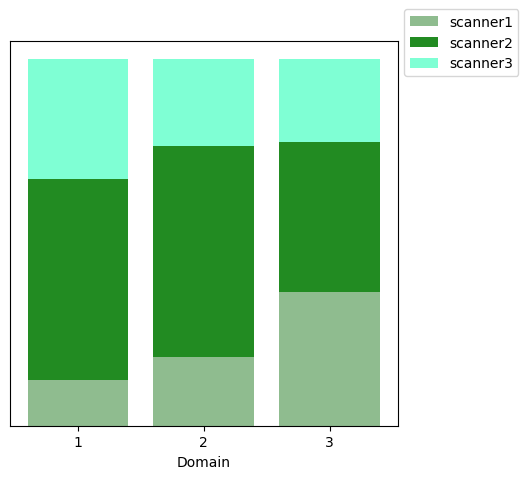

In [32]:
vec_y_counters = something_per_domain(domain, vec_y)
plot_something_per_domain_proportion(domain, vec_y, vec_y_counters, 10, legend = ['scanner1', 'scanner2', 'scanner3'], thres = None, title = None, digit_plot = True)

## DEC Experiments with HER2 data

In [ ]:
exp = mk_exp(task='her2',model='dec',trainer='cluster', train_domain ="0 1 2", test_domain="0", batchsize="4",
             dpath= HER2_PATH, zd_dim='500', model_method ='cnn',
             prior='Gaus', pre_tr=17, epos=50, d_dim='3',lr='0.000005', nocu=False, L=5)

In [ ]:
exp.execute()

In [ ]:
dec_path = get_last_created_directory('./notebooks/')
print(dec_path)

In [33]:
domain, vec_d, vec_y, img_locs, model_name, command_line = load_files('./notebooks/'+dec_path)

unique predicted domain [1 2 3]
unique true label [0 1 2]
unique labels [0 1 2]
[1 2 3]


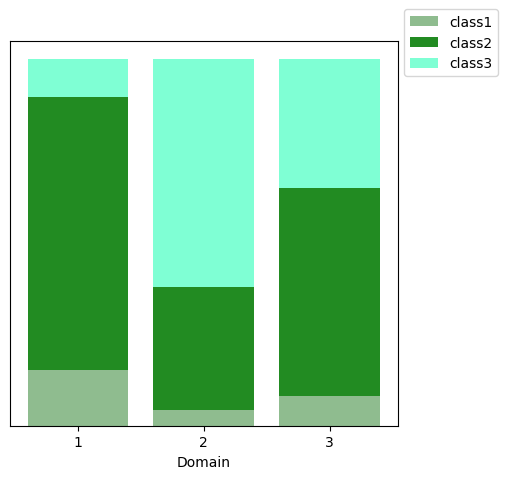

In [34]:
vec_d_counters = something_per_domain(domain, vec_d)
plot_something_per_domain_proportion(domain, vec_d, vec_d_counters, 10, legend = ['class1', 'class2', 'class3'], thres = None, title = None, digit_plot = True)

unique predicted domain [1 2 3]
unique true label [0 1 2]
unique labels [0 1 2]
[1 2 3]


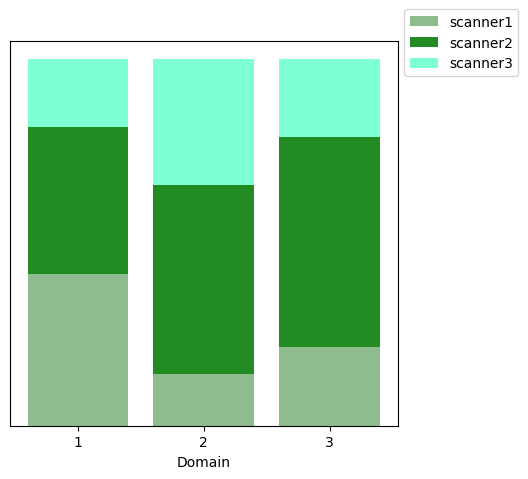

In [35]:
vec_y_counters = something_per_domain(domain, vec_y)
plot_something_per_domain_proportion(domain, vec_y, vec_y_counters, 10, legend = ['scanner1', 'scanner2', 'scanner3'], thres = None, title = None, digit_plot = True)

## CDVaDE Experiments with HER2 data

In [ ]:
exp = mk_exp(task='her2',model='vade',trainer='cluster', train_domain ="0 1 2", test_domain="0", batchsize="4",
             dpath=HER2_PATH, zd_dim='500', model_method ='cnn',
             prior='Gaus', pre_tr=17, epos=50, d_dim='3',lr='0.000005', dim_inject_y=3,
             meta_data_csv=os.path.join(HER2_PATH, 'dataframe.csv'),  inject_var='class', nocu=False, L=5)

In [ ]:
exp.execute()

In [ ]:
cdvade_path = get_last_created_directory('./notebooks/')

In [36]:
cdvade_path

'2024-04-17_10:39:22.988349_her2_vade'

In [37]:
domain, vec_d, vec_y, img_locs, model_name, command_line = load_files('./notebooks/'+cdvade_path)

unique predicted domain [1 2 3]
unique true label [0 1 2]
unique labels [0 1 2]
[1 2 3]


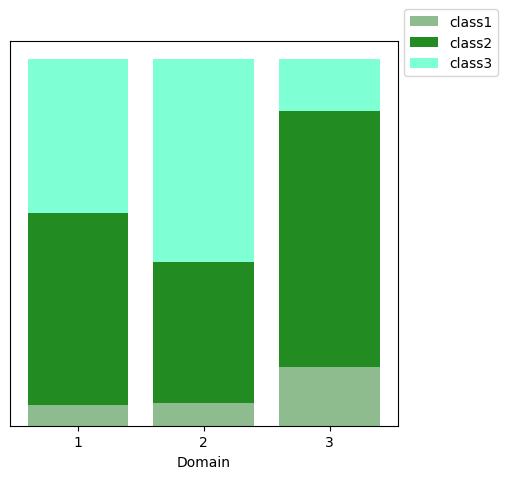

In [38]:
vec_d_counters = something_per_domain(domain, vec_d)
plot_something_per_domain_proportion(domain, vec_d, vec_d_counters, 10, legend = ['class1', 'class2', 'class3'], thres = None, title = None, digit_plot = True)

unique predicted domain [1 2 3]
unique true label [0 1 2]
unique labels [0 1 2]
[1 2 3]


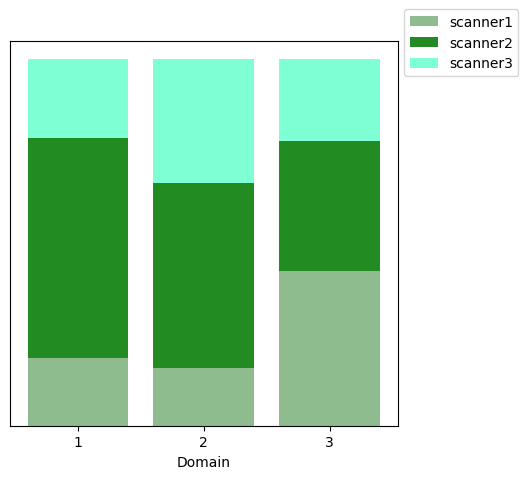

In [39]:
vec_y_counters = something_per_domain(domain, vec_y)
plot_something_per_domain_proportion(domain, vec_y, vec_y_counters, 10, legend = ['scanner1', 'scanner2', 'scanner3'], thres = None, title = None, digit_plot = True)

**To Perform further analysys, please follow to the notebook 'HER2_boxplot_visualizations.ipynb'!**

You will need the directories for the results of the experiments.

Example: 

ex_dec = './notebooks/2024-04-15_11:42:21.990399_her2_dec/'

ex_vade = './notebooks/2024-04-12_13:23:14.404120_her2_vade/'

Note that if you ran this entire notebook, then you have already assigned `vade_path`,`cdvade_path` and `dec_path`:

In [41]:
print(vade_path)
print(cdvade_path)
print(dec_path)

2024-04-17_09:30:14.239867_her2_vade
2024-04-17_10:39:22.988349_her2_vade
2024-04-17_10:05:16.944029_her2_dec
